# MVPA and Searchlight with `nilearn`

In this section we will show how you can use `nilearn` to perform multivariate pattern analysis (MVPA) and a Searchlight analysis.


## `nilearn`

Although nilearn's visualizations are quite nice, its primary purpose was to facilitate machine learning in neuroimaging. It's in some sense the bridge between [nibabel](http://nipy.org/nibabel/) and [scikit-learn](http://scikit-learn.org/stable/). On the one hand, it reformats images to be easily passed to scikit-learn, and on the other, it reformats the results to produce valid nibabel images.

So let's take a look at a short multi-variate pattern analysis (MVPA) example.

**Note 1**: This section is heavily based on the [nilearn decoding tutorial](https://nilearn.github.io/auto_examples/plot_decoding_tutorial.html).  
**Note 2**: This section is not intended to teach machine learning, but to demonstrate a simple nilearn pipeline.

## Setup

In [1]:
from nilearn import plotting
%matplotlib inline
import numpy as np
import nibabel as nb

## Load machine learning dataset

Let's load the dataset we prepared in the previous notebook:

In [2]:
func = '/home/neuro/workshop/notebooks/data/dataset_ML.nii.gz'
!nib-ls $func

/home/neuro/workshop/notebooks/data/dataset_ML.nii.gz float32 [ 40,  51,  41, 384] 4.00x4.00x4.00x1.00



## Create mask

As we only want to use voxels in a particular region of interest (ROI) for the classification, let's create a function that returns a mask that either contains the only the brain, only the eyes or both:

In [3]:
from nilearn.image import resample_to_img, math_img
from scipy.ndimage import binary_dilation

def get_mask(mask_type):
    
    # Specify location of the brain and eye image
    brain = '/home/neuro/workshop/notebooks/data/templates/MNI152_T1_1mm_brain.nii.gz'
    eyes = '/home/neuro/workshop/notebooks/data/templates/MNI152_T1_1mm_eye.nii.gz'

    # Load region of interest
    if mask_type == 'brain':
        img_resampled = resample_to_img(brain, func)
    elif mask_type == 'eyes':
        img_resampled = resample_to_img(eyes, func)
    elif mask_type == 'both':
        img_roi = math_img("img1 + img2", img1=brain, img2=eyes)
        img_resampled = resample_to_img(img_roi, func)

    # Binarize ROI template
    data_binary = np.array(img_resampled.get_fdata()>=10, dtype=np.int8)

    # Dilate binary mask once
    data_dilated = binary_dilation(data_binary, iterations=1).astype(np.int8)

    # Save binary mask in NIfTI image
    mask = nb.Nifti1Image(data_dilated, img_resampled.affine, img_resampled.header)
    mask.set_data_dtype('i1')
    
    return mask

## Masking and Un-masking data

For the classification with `nilearn`, we need our functional data in a 2D, sample-by-voxel matrix. To get that, we'll select all the voxels defined in our `mask`.

In [4]:
from nilearn.plotting import plot_roi

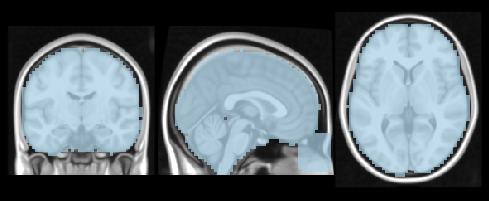

In [5]:
anat = '/home/neuro/workshop/notebooks/data/templates/MNI152_T1_1mm.nii.gz'
mask = get_mask('both')
plot_roi(mask, anat, cmap='Paired', dim=-.5, draw_cross=False, annotate=False)

`NiftiMasker` is an object that applies a mask to a dataset and returns the masked voxels as a vector at each time point.

In [6]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask, standardize=False, detrend=False,
                     memory="nilearn_cache", memory_level=2)
samples = masker.fit_transform(func)
print(samples)

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/input_data/base_masker.py:99: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_masker_extractor'
  memory_level=memory_level)(imgs)


[[0.7965089  0.9749323  0.9000536  ... 0.56139576 0.40530768 0.71668595]
 [0.9088199  0.7303408  0.63435954 ... 0.80835986 0.44824055 0.46237826]
 [0.6761813  0.8293086  0.9835918  ... 0.5358669  0.56062424 0.72024435]
 ...
 [0.81860083 0.8177914  1.0595632  ... 0.63843036 0.5614186  0.7092098 ]
 [0.8739697  0.6019776  1.0053024  ... 0.5492817  0.67479044 0.70944095]
 [0.8174745  0.9999173  0.9347665  ... 0.6070517  0.92529875 0.7956351 ]]


Its shape corresponds to the number of time-points times the number of voxels in the mask.

In [7]:
print(samples.shape)

(384, 37398)


To recover the original data shape (giving us a masked and z-scored BOLD series), we simply use the masker's inverse transform:

In [8]:
masked_epi = masker.inverse_transform(samples)

Let's now visualize the masked epi.

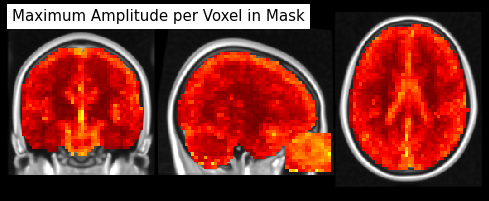

In [9]:
from nilearn.image import math_img
from nilearn.plotting import plot_stat_map

max_zscores = math_img("np.abs(img).max(axis=3)", img=masked_epi)
plot_stat_map(max_zscores, bg_img=anat, dim=-.5, cut_coords=[33, -20, 20],
              draw_cross=False, annotate=False, colorbar=False,
              title='Maximum Amplitude per Voxel in Mask')

# Simple MVPA Example

Multi-voxel pattern analysis (MVPA) is a general term for techniques that contrast conditions over multiple voxels. It's very common to use machine learning models to generate statistics of interest.

In this case, we'll use the response patterns of voxels in the mask to predict if the eyes were **closed** or **open** during a resting-state fMRI recording. But before we can do MVPA, we still need to specify two important parameters:

***First***, we need to know the label for each volume. From the last section of the [Machine Learning Preparation](machine_learning_preparation.ipynb) notebook, we know that we have a total of 384 volumes in our `dataset_ML.nii.gz` file and that it's always 4 volumes of the condition `eyes closed`, followed by 4 volumes of the condition `eyes open`, etc. Therefore our labels should be as follows:

In [10]:
labels = np.ravel([[['closed'] * 4, ['open'] * 4] for i in range(48)])
labels[:20]

array(['closed', 'closed', 'closed', 'closed', 'open', 'open', 'open',
       'open', 'closed', 'closed', 'closed', 'closed', 'open', 'open',
       'open', 'open', 'closed', 'closed', 'closed', 'closed'],
      dtype='<U6')

***Second***, we need the `chunks` parameter. This variable is important if we want to do for example cross-validation. In our case we would ideally create 48 chunks, one for each subject. But because a cross-validation of 48 chunks takes very long, let's just create 6 chunks, containing always 8 subjects, i.e. 64 volumes:

In [11]:
chunks = np.ravel([[i] * 64 for i in range(6)])
chunks[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

One way to do cross-validation is the so called **Leave-one-out cross-validation**. This approach trains on `(n - 1)` chunks, and classifies the remaining chunk, and repeats this for every chunk, also called **fold**. Therefore, a 6-fold cross-validation is one that divides the whole data into 6 different chunks.

Now that we have the labels and chunks ready, we're only missing the classifier. In `Scikit-Learn`, there are [many to choose from](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html), let's start with the most well known, a linear support vector classifier (SVC).

In [12]:
# Let's specify the classifier
from sklearn.svm import LinearSVC
clf = LinearSVC(penalty='l2', loss='squared_hinge', max_iter=25)

**Note:** The number of maximum iterations should ideally be much much bigger (around 1000), but was kept low here to reduce computation time.

Now, we're ready to train the classifier and do the cross-validation.

In [13]:
# Performe the cross validation (takes time to compute)
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
cv_scores = cross_val_score(estimator=clf,
                            X=samples,
                            y=labels,
                            groups=chunks,
                            cv=LeaveOneGroupOut(),
                            n_jobs=-1,
                            verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   13.5s remaining:   27.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   16.4s finished


After the cross validation was computed we can extract the overall accuracy, as well as the accuracy for each individual fold (i.e. leave-one-out prediction). Mean (across subject) cross-validation accuracy is a common statistic for classification-based MVPA.

In [14]:
print('Average accuracy = %.02f percent\n' % (cv_scores.mean() * 100))
print('Accuracy per fold:', cv_scores, sep='\n')

Average accuracy = 85.16 percent

Accuracy per fold:
[0.796875 0.828125 0.796875 0.84375  0.9375   0.90625 ]


**Wow, an average accuracy above 80%!!!** What if we use another classifier? Let's say a Gaussian Naive Bayes classifier?

In [15]:
# Let's specify a Gaussian Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

In [16]:
cv_scores = cross_val_score(estimator=clf,
                            X=samples,
                            y=labels,
                            groups=chunks,
                            cv=LeaveOneGroupOut(),
                            n_jobs=1,
                            verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.6s finished


In [17]:
print('Average accuracy = %.02f percent\n' % (cv_scores.mean() * 100))
print('Accuracy per fold:', cv_scores, sep='\n')

Average accuracy = 79.43 percent

Accuracy per fold:
[0.75     0.796875 0.796875 0.796875 0.875    0.75    ]


That was much quicker but less accurate. As was expected. What about a Logistic Regression classifier?

In [18]:
# Let's specify a Logistic Regression classifier
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', max_iter=25)

In [19]:
cv_scores = cross_val_score(estimator=clf,
                            X=samples,
                            y=labels,
                            groups=chunks,
                            cv=LeaveOneGroupOut(),
                            n_jobs=-1,
                            verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   29.8s remaining:   59.6s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   34.0s finished


In [20]:
print('Average accuracy = %.02f percent\n' % (cv_scores.mean() * 100))
print('Accuracy per fold:', cv_scores, sep='\n')

Average accuracy = 85.16 percent

Accuracy per fold:
[0.828125 0.8125   0.8125   0.890625 0.875    0.890625]


The prediction accuracy is again above **80%**, much better! But anyhow, how do we know if an accuracy value is significant or not? Well, one way to find this out is to do some permutation testing.

## Permutation testing

One way to test the quality of the prediction accuracy is to run the cross-validation multiple times, but permutate the labels of the volumes randomly. Afterward we can compare the accuracy value of the correct labels to the ones with the random / false labels. Luckily `Scikit-learn` already has a function that does this for us. So let's do it.

**Note**: We chose again the `GaussianNB` classifier to reduce the computation time per cross-validation. Additionally, we chose the number of iterations under `n_permutations` for the permutation testing very low, to reduce computation time as well. This value should ideally be much higher, at least 100.

In [21]:
# Let's chose again the linear SVC
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

In [22]:
# Import the permuation function
from sklearn.model_selection import permutation_test_score

In [23]:
# Run the permuation cross-validation
null_cv_scores = permutation_test_score(estimator=clf,
                                        X=samples,
                                        y=labels,
                                        groups=chunks,
                                        cv=LeaveOneGroupOut(),
                                        n_permutations=25,
                                        n_jobs=-1,
                                        verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   22.9s finished


So, let's take a look at the results:

In [24]:
print('Prediction accuracy: %.02f' % (null_cv_scores[0] * 100),
      'p-value: %.04f' % (null_cv_scores[2]),
      sep='\n')

Prediction accuracy: 79.43
p-value: 0.0385


Great! This means... Using resting-state fMRI images, we can predict if a person had their eyes open or closed with an accuracy significantly above chance level!

# Which region is driving the classification?

With a simple MVPA approach, we unfortunately don't know which regions are driving the classification accuracy. We just know that all voxels in the mask allow the classification of the two classes, but why? We need a better technique that tells us where in the head we should look.

There are many different ways to figure out which region is important for classification, but let us introduce you two different approaches that you can use in `nilearn`: `SpaceNet` and  `Searchlight`

## SpaceNet: decoding with spatial structure for better maps

SpaceNet implements spatial penalties which improve brain decoding power as well as decoder maps. The results are brain maps which are both sparse (i.e regression coefficients are zero everywhere, except at predictive voxels) and structured (blobby). For more detail, check out `nilearn`'s section about [SpaceNet](http://nilearn.github.io/decoding/space_net.html).

To train a SpaceNet on our data, let's first split the data into a training set (chunk 0-4) and a test set (chunk 5). 

In [25]:
# Create two masks that specify the training and the test set 
mask_test = chunks == 5
mask_train = np.invert(mask_test)

In [26]:
# Apply this sample mask to X (fMRI data) and y (behavioral labels)
from nilearn.image import index_img
X_train = index_img(func, mask_train)
y_train = labels[mask_train]

X_test = index_img(func, mask_test)
y_test = labels[mask_test]

Now we can fit the SpaceNet to our data with a TV-l1 penalty. ***Note*** again, that we reduced the number of `max_iter` to have a quick computation. In a realistic case this value should be around 1000.

In [27]:
from nilearn.decoding import SpaceNetClassifier

# Fit model on train data and predict on test data
decoder = SpaceNetClassifier(penalty='tv-l1',
                             mask=get_mask('both'),
                             max_iter=10,
                             cv=5,
                             standardize=True,
                             memory="nilearn_cache",
                             memory_level=2,
                             verbose=1)

decoder.fit(X_train, y_train)

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(40, 51, 41, 320),
affine=array([[  -4.,    0.,    0.,   78.],
       [   0.,    4.,    0., -114.],
       [   0.,    0.,    4.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/decoding/space_net.py:836: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  self.screening_percentile, self.mask_img_, verbose=self.verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f77ccf8ddd0>, loss='logistic'), array([[0.588454, ..., 0.029157],
       ...,
       [0.678369, ..., 2.213025]]), array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 64, ..., 319]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]), 
{'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 0), debias=False, verbose=1, screening_percentile=15.268555470880802)
_____________________________

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f77ccf8ddd0>, loss='logistic'), array([[0.588454, ..., 0.029157],
       ...,
       [0.678369, ..., 2.213025]]), array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([  0, ..., 319]), array([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]), 
{'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 1), debias=False, verbose=1,

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   58.4s finished


SpaceNetClassifier(alphas=None, cv=5, debias=False, eps=0.001,
          fit_intercept=True, high_pass=None, l1_ratios=0.5,
          loss='logistic', low_pass=None,
          mask=<nibabel.nifti1.Nifti1Image object at 0x7f77ccfcd190>,
          max_iter=10, memory=Memory(location=nilearn_cache/joblib),
          memory_level=2, n_alphas=10, n_jobs=1, penalty='tv-l1',
          screening_percentile=20.0, standardize=True, t_r=None,
          target_affine=None, target_shape=None, tol=0.0001, verbose=1)

Now that the `SpaceNet` is fitted to the training data. Let's see how well it does in predicting the test data.

In [28]:
# Predict the labels of the test data
y_pred = decoder.predict(X_test)

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(40, 51, 41, 64),
affine=array([[  -4.,    0.,    0.,   78.],
       [   0.,    4.,    0., -114.],
       [   0.,    0.,    4.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


In [29]:
# Retrun average accuracy
accuracy = (y_pred == y_test).mean() * 100.
print("\nTV-l1  classification accuracy : %g%%" % accuracy)


TV-l1  classification accuracy : 85.9375%


Again above 80% prediction accuracy? But we wanted to know what's driving this prediction. So let's take a look at the fitting coefficients.

In [30]:
from nilearn.plotting import plot_stat_map, show
coef_img = decoder.coef_img_

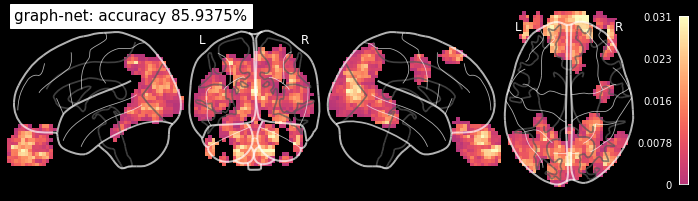

In [31]:
# Plotting the searchlight results on the glass brain
from nilearn.plotting import plot_glass_brain
plot_glass_brain(coef_img, black_bg=True, colorbar=True, display_mode='lyrz', symmetric_cbar=False,
                 cmap='magma', title='graph-net: accuracy %g%%' % accuracy)

Cool! As expected the visual cortex (in the back of the head) and the eyes are driving the classification!

## Searchlight

Now the next question is: How high would the prediction accuracy be if we only take one small region to do the classification?

To answer this question we can use something that is called a **Searchlight** approach. The searchlight approach was first proposed by [Kriegeskorte et al., 2006](https://pdfs.semanticscholar.org/985c/ceaca8606443f9129616a26bbbbf952f2d7f.pdf). It is a widely used approach for the study of the fine-grained patterns of information in fMRI analysis. Its principle is relatively simple: a small group of neighboring features is extracted from the data, and the prediction function is instantiated on these features only. The resulting prediction accuracy is thus associated with all the features within the group, or only with the feature on the center. This yields a map of local fine-grained information, that can be used for assessing hypothesis on the local spatial layout of the neural code under investigation.

You can do a searchlight analysis in `nilearn` as follows:

In [32]:
from nilearn.decoding import SearchLight

In [33]:
# Specify the mask in which the searchlight should be performed
mask = get_mask('both')

In [34]:
# Specify the classifier to use
# Let's use again a GaussainNB classifier to reduce computation time
clf = GaussianNB()

In [35]:
# Specify the radius of the searchlight sphere  that will scan the volume
# (the bigger the longer the computation)
sphere_radius = 8  # in mm

Now we're ready to create the searchlight object.

In [36]:
# Create searchlight object
sl = SearchLight(mask,
                 process_mask_img=mask,
                 radius=sphere_radius,
                 estimator=clf,
                 cv=LeaveOneGroupOut(),
                 n_jobs=-1,
                 verbose=1)

In [37]:
# Run the searchlight algorithm
sl.fit(nb.load(func), labels, groups=chunks)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:  2.9min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.9min finished


SearchLight(cv=LeaveOneGroupOut(),
      estimator=GaussianNB(priors=None, var_smoothing=1e-09),
      mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f77ccf26e10>,
      n_jobs=-1,
      process_mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f77ccf26e10>,
      radius=8, scoring=None, verbose=1)

That took a while. So let's take a look at the results.

In [38]:
# First we need to put the searchlight output back into an MRI image
from nilearn.image import new_img_like
searchlight_img = new_img_like(func, sl.scores_)

Now we can plot the results. Let's plot it once on the glass brain and once from the side. For better interpretation on where the peaks are, let's set a minimum accuracy threshold of 60%.

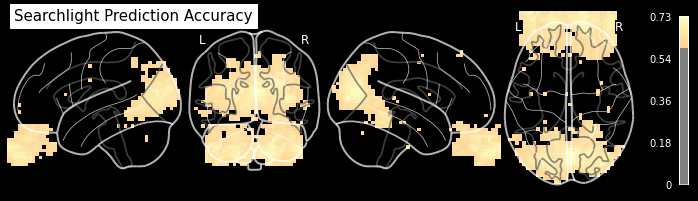

In [39]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(searchlight_img, black_bg=True, colorbar=True, display_mode='lyrz',
                 threshold=0.6, cmap='magma', title='Searchlight Prediction Accuracy')

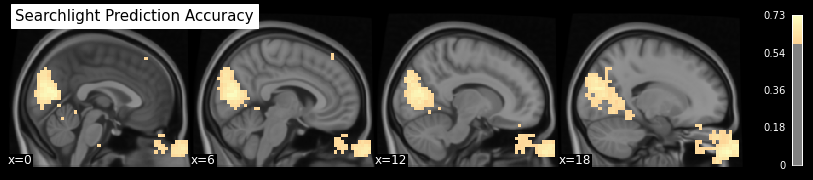

In [40]:
from nilearn.plotting import plot_stat_map
plot_stat_map(searchlight_img, cmap='magma', bg_img=anat, colorbar=True,
              display_mode='x', threshold=0.6, cut_coords=[0, 6, 12, 18],
              title='Searchlight Prediction Accuracy');

As expected and already seen before, the hotspots with high prediction accuracy are around the primary visual cortex (in the back of the head) and around the eyes.